# <font color="maroon">Template: Cross-Correlated Dynamics via iRED</font>

<a href="https://githubtocolab.com/alsinmr/pyDR_tutorial/blob/main/ColabNotebooks/Tpl_CCana.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

Cross-correlated analysis is relatively straightforward to execute, require just the path to the MD trajectory, bond selection, rank, number of detectors, etc.

## Parameters
Below, you find the parameters you would typically change for your own analysis

In [3]:
#Where's  your data??
topo='../pyDR/examples/HETs15N/backboneB.pdb'
traj_files=['../pyDR/examples/HETs15N/backboneB.xtc']  #Can be multiple files

# Step (how many MD frames to skip. Set to 1 to use all frames)
step=10

# How many detectors
n=6

# iRED rank (1 or 2)
rank=1

#What Nucleus did you measure?
bond='N'  #This refers to the backbone nitrogen, specifically
segids=None # Usually, segment does not need to be specified

# Do you want to save the results somewhere?
directory=None  #Path to project directory

## Setup and data downloads
Since we've learned now how pyDR is organized and allows us to manage larger data sets, we'll now use the full project functionality.

In [0]:
# SETUP pyDR
import os
os.chdir('..')
import sys
sys.path.append('../') # Path to pyDR location

In [5]:
#Imports
import pyDR

In [16]:
# Project Creation and File loading
proj=pyDR.Project(directory=directory,create=directory is not None)

sel=pyDR.MolSelect(topo=topo,
                   traj_files=traj_files,
                   project=proj)  #Selection object

# Specify the bond select to analyze for MD
sel.select_bond(bond)

## Load and process MD without and with iRED
When using iRED, it's important to compare the dynamics obtained with iRED and with a direct calculation of the detector responses. iRED works by determining modes of reorientational motion that are independent from each other. Then, the cross-correlation between modes is, by definition, zero at the initial time. However, there is no guarantee that the modes remain independent at a later time. If the direct and iRED calculations are in good agreement for a given bond, then the majority of motion for that bond results from independent mode motions which remain mostly independent. However, if not, then the total motion of that bond may have significant contributions from [time-lagged cross-correlation](https://pubs.aip.org/aip/jcp/article/139/1/015102/192538/Identification-of-slow-molecular-order-parameters) between modes, and the iRED analysis is especially representative of its total motion.

Note that we'll do a rank 1 calculation here for iRED, since it simplifies the orientational dependence of iRED.

### Create raw data 

In [17]:
sel.traj.step=step  #Take every tenth point for MD calculation (set to 1 for more accurate calculation)
pyDR.Defaults['ProgressBar']=False #Turns off the Progress bar (screws up webpage compilation)

pyDR.md2data(sel,rank=rank) #Direct calculation
ired=pyDR.md2iRED(sel,rank=rank)  #iRED object
ired.iRED2data() #Send iRED results to proj

r:IREDMODE:rk1:backboneB with 70 data points


Next, we set up the detectors for the raw data. We'll do a pre-processing with 10 unoptimized detectors.

### Fit to unoptimized detectors

In [18]:
proj['raw'].detect.r_no_opt(15)
proj['raw'].fit()

Fitted 2 data objects
pyDIFRATE project with 2 data sets

Titles:
n15:MD:rk1:backboneB
n15:IREDMODE:rk1:backboneB


### Fit to optimized detectors + optimized fit

In [19]:
proj['no_opt'].detect.r_auto(n)
proj['no_opt'].fit().opt2dist(rhoz_cleanup=True)

Fitted 2 data objects
Optimized 2 data objects
pyDIFRATE project with 2 data sets

Titles:
o6:MD:rk1:backboneB
o6:IREDMODE:rk1:backboneB


### Convert modes to bonds

In [20]:
proj['opt_fit'].modes2bonds()

Converted 1 iRED data objects from modes to bonds
pyDIFRATE project with 1 data sets

Titles:
o6:IREDBOND:rk1:backboneB


## Plots
### Plot mode analysis

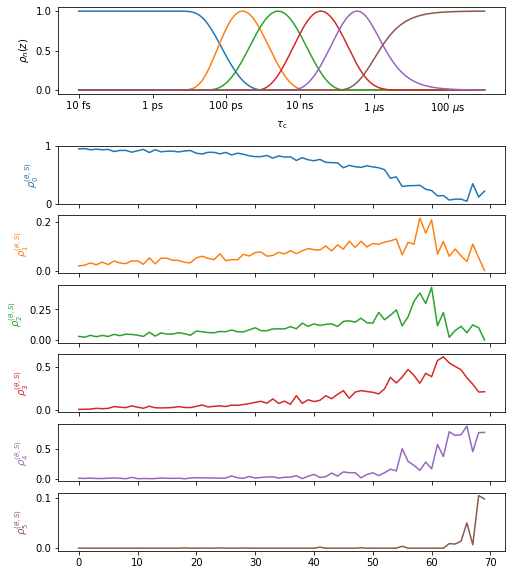

In [21]:
proj.close_fig('all')
proj['opt_fit']['iREDmode'].plot().fig.set_size_inches([8,10])

### Compare iRED to direct analysis

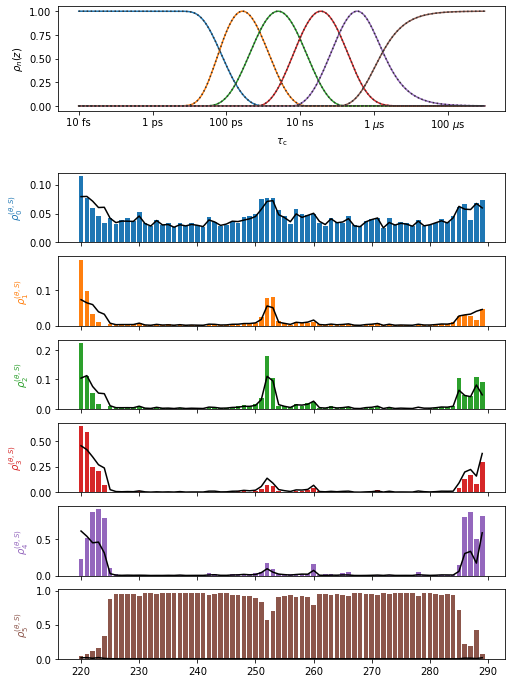

In [23]:
proj.close_fig('all')
proj['opt_fit']['MD'].plot(style='bar').fig.set_size_inches([8,12])
proj['opt_fit']['iREDbond'].plot()

In particularly flexible regions, there is some disagreement between the two analyses, but otherwise we have done fairly well with the iRED mode decomposition. In these flexible regions, we should keep in mind that mode dynamics yields an incomplete description of the total motion and the cross-correlation coefficients are not representing the full motion.

### Plotting cross-correlation matrix
We first plot the cross-correlation matrices (using the absolute normalized cross-correlation, ranging from 0 to 1).

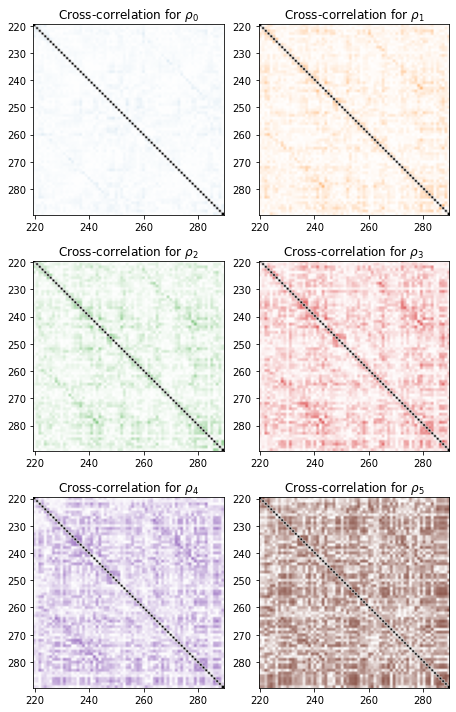

In [24]:
import numpy as np
fig=proj['opt_fit']['iREDbond'].plot_CC('all')[0].figure
fig.set_size_inches([12,10])
fig.tight_layout()

### 3D Representations in ChimeraX
Finally, if running locally, we can plot in ChimeraX. In ChimeraX, we can select a given bond (or atom in the bond/representative selection), and then mouse over one of the detectors in the upper right corner to view the cross-correlation to the selected bond.

In [26]:
# proj.chimera.close()
proj['iREDbond'].CCchimera()
_=proj.chimera.command_line(['set bgColor white','lighting soft','~show ~@N,C,CA,H,N'])